In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

SCRIPT_DIR = Path('/home/alina.smolina/DL-pipeline/src')
sys.path.append(str(SCRIPT_DIR))

In [3]:
import torch
import time
import glob

RuntimeError: KeyboardInterrupt: <EMPTY MESSAGE>

In [4]:
torch.set_float32_matmul_precision('high')

In [5]:
import wandb

In [6]:
import pytorch_lightning as pl

🪄: shape of the resulting tensor is (10, 3450, 2700)


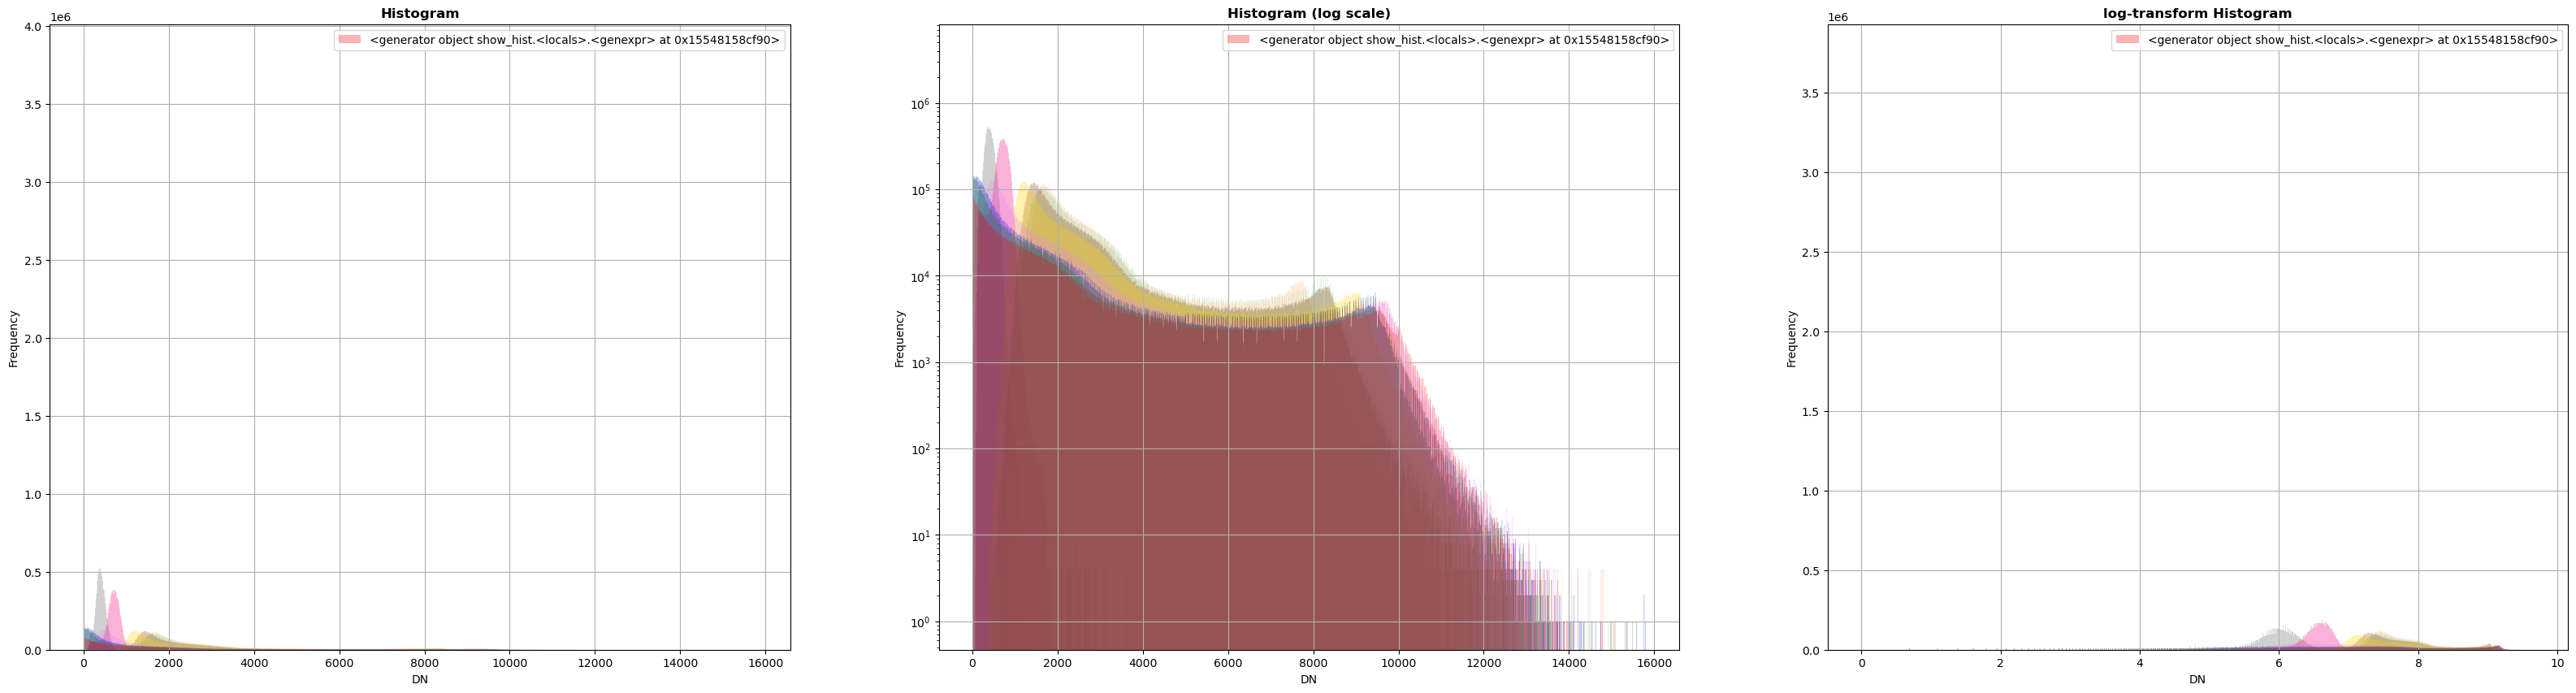

🪄: shape of the resulting tensor is (10, 1950, 1200)


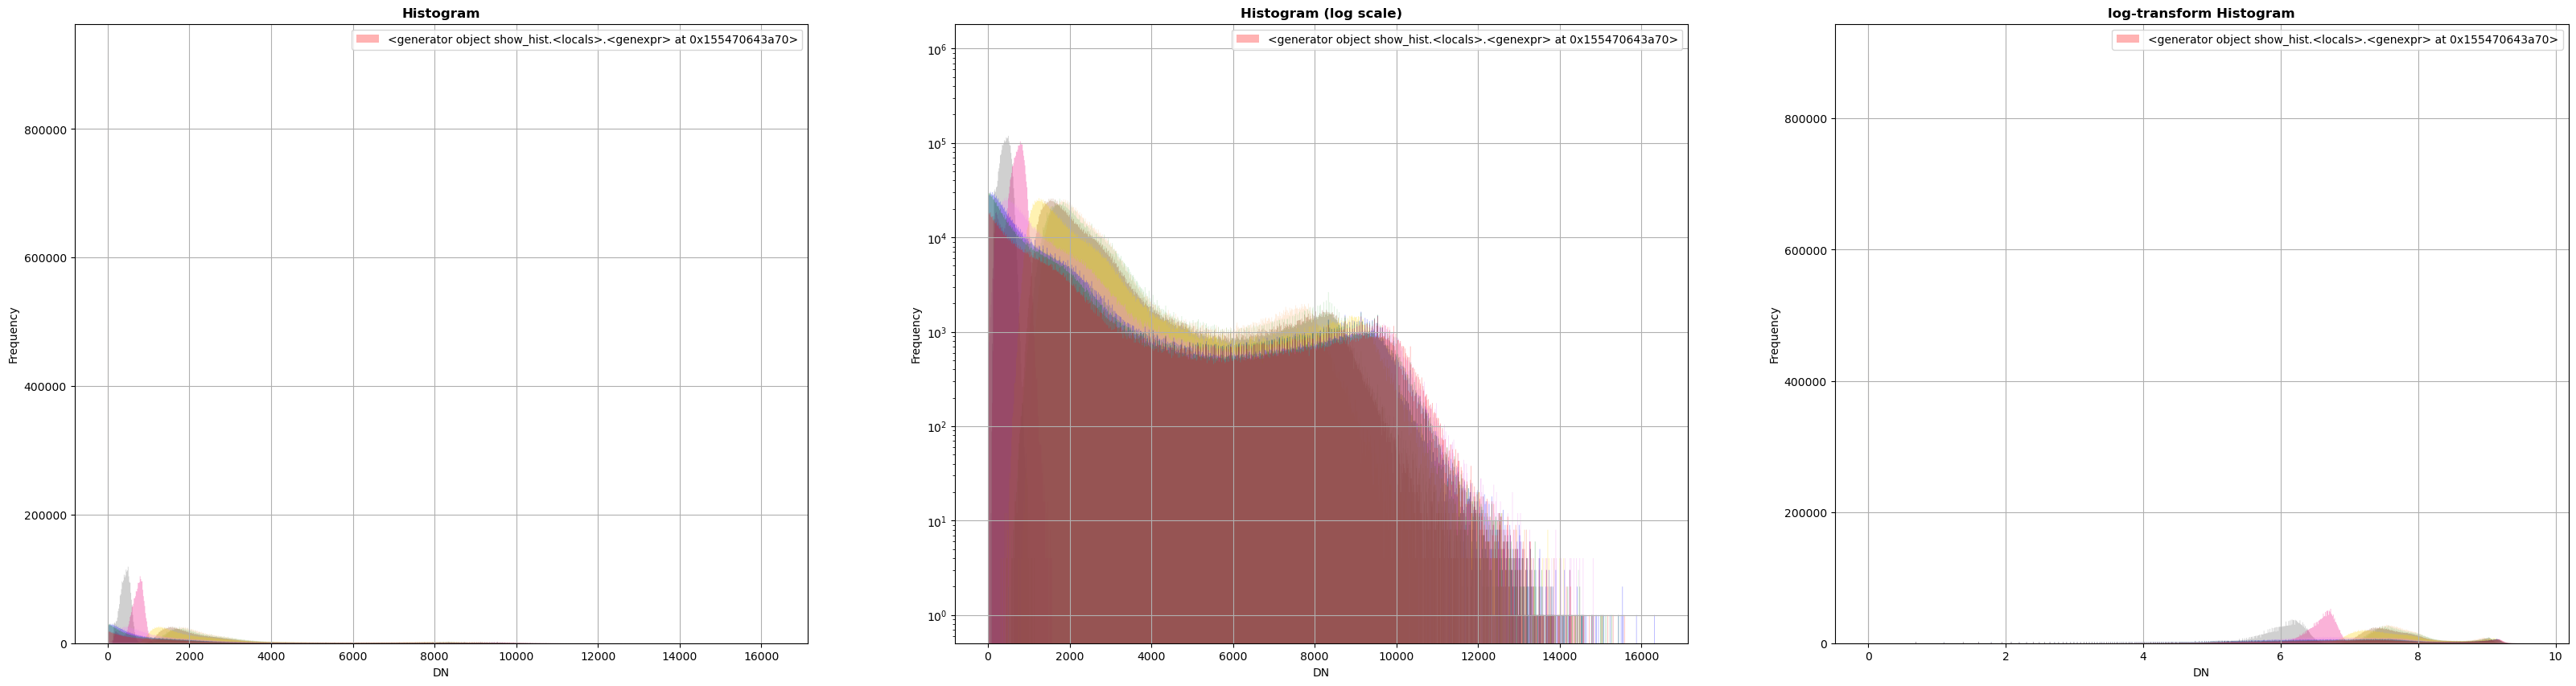

🪄: shape of the resulting tensor is (1, 3450, 2700)
🪄: shape of the resulting tensor is (1, 1950, 1200)
🪄: shape of the resulting tensor is (1, 3450, 2700)
🪄: shape of the resulting tensor is (1, 1950, 1200)


In [7]:
import matplotlib.pyplot as plt
from rasterio.windows import Window
import pandas as pd
import rasterio
import numpy as np
from rasterio.plot import show_hist
from pprint import pprint


#### -------------------------------> [x]
####|          ____________
####|         |            |
####|         |            |
####|         |            |
####|   (0, a).____________.(w, a)
####|         |            |
####|         |            |
####|         |            |
####|   (h, a).____________.(w, h)
####|
####|
####\/ [y]



y0, x0 = 6000, 0
train_window = Window.from_slices((y0, y0 + 4000), (x0, x0 + 2700))

y0, x0 = 0, 5700
window_r = Window.from_slices((y0, y0 + 7000), (x0, x0 + 10000))

### Test
y0, x0 = 7500, 2700
test_window = Window.from_slices((y0, y0 + 3000), (x0, x0 + 1200))


images_dir = './../../data/arkhangelsk/tile_UTM38N/20180406'
channels_list = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

target_dir = './../../data/arkhangelsk/tile_UTM38N/rasterized'
target = 'filt_group_2classes'



def get_data(channels_list, path, window=None, get_stat=False):
    channels = []
    for ch in channels_list:
        with rasterio.open(f'{path}/{ch}.tif') as src:
            if window is None:
                channels += [src.read(1)]
            else:
                channels += [src.read(1, window=window)]

    multispectral_img = np.stack(channels)
    print(f'🪄: shape of the resulting tensor is {multispectral_img.shape}')
    
    band_stats = {}
    
    if get_stat:
        
        flattened_multispectral_img = multispectral_img.reshape(multispectral_img.shape[0], -1)
        maximums = np.max(flattened_multispectral_img, axis=-1)
        minimums = np.min(flattened_multispectral_img, axis=-1)
        means = np.mean(flattened_multispectral_img, axis=-1)
        stds = np.std(flattened_multispectral_img, axis=-1)
        percentiles_99 = np.percentile(flattened_multispectral_img, q=99, axis=-1)
        percentiles_1 = np.percentile(flattened_multispectral_img, q=1, axis=-1)
        for i, ch in enumerate(channels_list):
            band_stats[ch] = {
                'min': minimums[i], 
                'max': maximums[i], 
                'mean': means[i], 
                'std': stds[i],
                'percentile_99': percentiles_99[i],
                'percentile_1': percentiles_1[i],
            }
        
        fig, axes = plt.subplots(1, 3, figsize=(40, 10))
        hist_params = {
            'bins': 1000, 
            'lw': 0.0,
            'stacked': False,
            'alpha': 0.3,
            'histtype': 'stepfilled',
        }
        show_hist(multispectral_img, title="Histogram", ax=axes[0], **hist_params)
        show_hist(multispectral_img, title="Histogram (log scale)", log=True, ax=axes[1], **hist_params)
        show_hist(np.log(multispectral_img), title="log-transform Histogram", ax=axes[2], **hist_params)
        plt.show()

    return multispectral_img, band_stats


X_train, band_stats_train = get_data(channels_list, images_dir, window=train_window, get_stat=True)
X_test, _ = get_data(channels_list, images_dir, window=test_window, get_stat=True)

SCL_train, _ = get_data(['SCL'], images_dir, window=train_window)
SCL_test, _ = get_data(['SCL'], images_dir, window=test_window)

Y_train, _ = get_data([target], target_dir, window=train_window) 
Y_test, _ = get_data([target], target_dir, window=test_window)

# so that class indices are in the range [0,C) (for torch.nn.CrossEntropy)
# Y_train = Y_train - 1
# Y_test = Y_test - 1

In [8]:
np.unique(Y_train, return_counts=True)

(array([  0,   1, 255], dtype=uint8), array([1065879, 1507971, 6741150]))

In [30]:
from datamodule import GeoModule 
import albumentations as A
import albumentations.pytorch as AP

transforms = A.Compose([
    # A.RandomCrop(256, 256),
    A.Flip(p=0.3),
    A.ShiftScaleRotate(
        shift_limit=(-0.0625, 0.0625), 
        scale_limit=0, #no scale
        rotate_limit=(-90, 90), 
        p=0.5
    ),
    AP.ToTensorV2(transpose_mask=True),
    ],
    additional_targets={'mask0': 'mask'}
)


one_date = GeoModule(
    X_train, 
    Y_train, 
    X_test, 
    Y_test,
    SCL_train,
    SCL_test,
    transform=transforms,
    batch_size=64,
    patch_size=128, #256, # 128
    stride=64, #128, # 64
    norm_strategy='min_max',
    num_workers=24, 
)

In [13]:
import wandb
from module import SegModule
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor

WANDB__SERVICE_WAIT=300
wandb_logger = WandbLogger(project='dl-pipeline-archangelsk', log_model=True)
print(f'🤖: Look at {wandb.run.url}')


lr_monitor_callback = LearningRateMonitor(logging_interval='step')


checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'../weights/group-2classes-archangelsk/{wandb.run.name}/',
    filename='{epoch}-{val_loss:.2f}', 
    monitor='val/mean_acc',
    mode='max',
    save_top_k=1
)

                   
trainer = pl.Trainer(
    max_epochs=40, 
    benchmark=True, 
    check_val_every_n_epoch=10, 
    logger=wandb_logger, 
    callbacks=[
        checkpoint_callback,
        lr_monitor_callback,
              ],
)

model = SegModule(
    optimizer='Adam', 
    scheduler='StepLR',
    step_size=50,
    gamma=0.1,
    lr=6e-3,
    in_channels=len(channels_list),
    num_classes=2, 
    ignore_index=255,
    class_labels_dict={0: 'лиственные', 1: 'хвойные', 255:'нет_данных'},
    labels_to_calc_metric=['лиственные', 'хвойные'],
    possible_classes=[0, 1]
)

trainer.fit(model, one_date)

wandb: Currently logged in as: nali. Use `wandb login --relogin` to force relogin


🤖: Look at https://wandb.ai/nali/dl-pipeline-archangelsk/runs/lfnx8sxh


/trinity/home/alina.smolina/.conda/envs/geotorch/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /trinity/home/alina.smolina/.conda/envs/geotorch/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


🤖: Setup data...
🤖: percentile_99 = [9728. 9520. 9504. 9789. 9178. 8502. 8520. 7911. 1020.  681.]
🤖: percentile_1 = [1.000e+00 1.000e+00 1.000e+00 1.850e+02 8.750e+02 1.088e+03 1.158e+03
 1.306e+03 1.590e+02 1.380e+02]
🤖: Dataset initialized:
🤖: ><><><><><><><><><> max_percentage_of_nodata_pixels = 0.6
🤖: ><><><><><><><><><> 317 patches were skipped
🤖: ><><><><><><><><><> 183 are remaining


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type                       | Params
-----------------------------------------------------------------
0  | net              | UNet                       | 16.5 M
1  | loss_fn          | CrossEntropyLoss_notmasked | 0     
2  | train_precision  | ClasswiseWrapper           | 0     
3  | train_recall     | ClasswiseWrapper           | 0     
4  | train_f1score    | ClasswiseWrapper           | 0     
5  | train_mean_acc   | MulticlassAccuracy         | 0     
6  | val_conf_matrix  | MulticlassConfusionMatrix  | 0     
7  | val_precision    | ClasswiseWrapper           | 0     
8  | val_recall       | ClasswiseWrapper           | 0     
9  | val_f1score      | ClasswiseWrapper           | 0     
10 | val_mean_acc     | MulticlassAccuracy         | 0     
11 | test_conf_matrix | MulticlassConfusionMatrix  | 0     
12 | test_precision   | ClasswiseWrapper           | 0     
13 | test_recall      | ClasswiseWrapper           

Sanity Checking: 0it [00:00, ?it/s]

🤖: #iterations in val dataloader: 1
🤖: #iterations in train dataloader: 3


/trinity/home/alina.smolina/.conda/envs/geotorch/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
trainer.test(model, one_date)

In [ ]:
ckpt_path

In [29]:
import wandb
from module import SegModule
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor

WANDB__SERVICE_WAIT=300
wandb_logger = WandbLogger(project='dl-pipeline-archangelsk', log_model=True, id='z4i809wu', resume='must')
print(f'🤖: Look at {wandb.run.url}')


# lr_monitor_callback = LearningRateMonitor(logging_interval='step')


# checkpoint_callback = pl.callbacks.ModelCheckpoint(
#     dirpath=f'../weights/group-2classes-archangelsk/{wandb.run.name}/',
#     filename='{epoch}-{val_loss:.2f}', 
#     monitor='val/mean_acc',
#     mode='max',
#     save_top_k=1
# )

                   
# trainer = pl.Trainer(
#     max_epochs=500, 
#     benchmark=True, 
#     check_val_every_n_epoch=10, 
#     logger=wandb_logger, 
#     callbacks=[
#         checkpoint_callback,
#         lr_monitor_callback,
#               ],
# )

trainer.test(
    model, 
    datamodule=one_date, 
    ckpt_path='/beegfs/home/alina.smolina/DL-pipeline/weights/group-2classes-archangelsk/solar-water-12/epoch=369-val_loss=0.00.ckpt'
)

Restoring states from the checkpoint path at /beegfs/home/alina.smolina/DL-pipeline/weights/group-2classes-archangelsk/solar-water-12/epoch=369-val_loss=0.00.ckpt


🤖: Look at https://wandb.ai/nali/dl-pipeline-archangelsk/runs/lfnx8sxh
🤖: Setup data...
🤖: Dataset initialized:
🤖: ><><><><><><><><><> Total #patches: 28 [7 x 4]
🤖: ><><><><><><><><><> 158px are left in vertical direction
🤖: ><><><><><><><><><> 176px are left in horizontal direction
🤖: ><><><><><><><><><> (28, 256, 256, 1) | #patches x patch_size x patch_size x 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /beegfs/home/alina.smolina/DL-pipeline/weights/group-2classes-archangelsk/solar-water-12/epoch=369-val_loss=0.00.ckpt


🤖: #iterations in test dataloader: 1


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test/f1score_лиственные    0.8998587727546692
  test/f1score_хвойные      0.8865122199058533
      test/mean_acc         0.8925443887710571
test/precision_лиственные   0.8822575211524963
 test/precision_хвойные     0.9070191383361816
 test/recall_лиственные     0.9181766510009766
   test/recall_хвойные      0.8669120669364929
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/mean_acc': 0.8925443887710571,
  'test/precision_лиственные': 0.8822575211524963,
  'test/precision_хвойные': 0.9070191383361816,
  'test/recall_лиственные': 0.9181766510009766,
  'test/recall_хвойные': 0.8669120669364929,
  'test/f1score_лиственные': 0.8998587727546692,
  'test/f1score_хвойные': 0.8865122199058533}]

In [31]:
trainer.test(
    model, 
    datamodule=one_date, 
    ckpt_path='/beegfs/home/alina.smolina/DL-pipeline/weights/group-2classes-archangelsk/solar-water-12/epoch=369-val_loss=0.00.ckpt'
)

🤖: Setup data...
🤖: percentile_99 = [9728. 9520. 9504. 9789. 9178. 8502. 8520. 7911. 1020.  681.]
🤖: percentile_1 = [1.000e+00 1.000e+00 1.000e+00 1.850e+02 8.750e+02 1.088e+03 1.158e+03
 1.306e+03 1.590e+02 1.380e+02]


Restoring states from the checkpoint path at /beegfs/home/alina.smolina/DL-pipeline/weights/group-2classes-archangelsk/solar-water-12/epoch=369-val_loss=0.00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🤖: Dataset initialized:
🤖: ><><><><><><><><><> Total #patches: 135 [15 x 9]
🤖: ><><><><><><><><><> 30px are left in vertical direction
🤖: ><><><><><><><><><> 48px are left in horizontal direction
🤖: ><><><><><><><><><> (135, 128, 128, 1) | #patches x patch_size x patch_size x 1


Loaded model weights from the checkpoint at /beegfs/home/alina.smolina/DL-pipeline/weights/group-2classes-archangelsk/solar-water-12/epoch=369-val_loss=0.00.ckpt


🤖: #iterations in test dataloader: 3


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test/f1score_лиственные    0.9003631472587585
  test/f1score_хвойные      0.8770899176597595
      test/mean_acc         0.8873453140258789
test/precision_лиственные    0.88253253698349
 test/precision_хвойные     0.8995084762573242
 test/recall_лиственные     0.9189291000366211
   test/recall_хвойные      0.8557615876197815
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/mean_acc': 0.8873453140258789,
  'test/precision_лиственные': 0.88253253698349,
  'test/precision_хвойные': 0.8995084762573242,
  'test/recall_лиственные': 0.9189291000366211,
  'test/recall_хвойные': 0.8557615876197815,
  'test/f1score_лиственные': 0.9003631472587585,
  'test/f1score_хвойные': 0.8770899176597595}]